In [43]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_cluster import knn_graph
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import awkward as ak


In [44]:
rng = np.random.default_rng(187)

num_graphs = 2#256
upper_limit = 30

graphsizes = rng.random((num_graphs))*upper_limit + 10
graphsizes = graphsizes.astype(int)

In [45]:
graphsizes

array([17, 20])

In [46]:
# make node features and labels
node_features = []
for size in graphsizes:
    node_features.append(rng.random((2, size)))
    
print(node_features)

[array([[0.50497268, 0.30376072, 0.85254749, 0.57692297, 0.68358927,
        0.15151507, 0.49460399, 0.04493635, 0.68163249, 0.49044509,
        0.93487639, 0.87493527, 0.1746896 , 0.71353164, 0.51161851,
        0.65875606, 0.70929701],
       [0.77012013, 0.45871582, 0.26598679, 0.38547232, 0.73055938,
        0.07995353, 0.69977181, 0.16971805, 0.23736594, 0.01595557,
        0.63068865, 0.39782817, 0.24694307, 0.53156348, 0.28152274,
        0.87072021, 0.59166661]]), array([[0.30785326, 0.12736179, 0.36090577, 0.02132952, 0.59150147,
        0.10069786, 0.76869805, 0.82284753, 0.08082336, 0.3756163 ,
        0.59513113, 0.14044215, 0.89240386, 0.09276061, 0.36173728,
        0.77931311, 0.19904609, 0.41583237, 0.24547304, 0.74239643],
       [0.7994411 , 0.54647538, 0.44602289, 0.83827665, 0.6641264 ,
        0.46888605, 0.80402179, 0.96720156, 0.55659944, 0.83670978,
        0.91504787, 0.18519766, 0.83188091, 0.22132845, 0.82040497,
        0.5355099 , 0.1511573 , 0.85639094, 0.

In [75]:
# labels and transpose nodes into proper format and make edges
num_edges = 2
labels = []
edges = []
for i in range(len(node_features)):
    labels.append([node_features[i][0].mean(), node_features[i][1].mean()])
    node_features[i] = torch.Tensor(np.transpose(node_features[i]))
    edges.append(knn_graph(torch.Tensor(np.transpose(node_features[i])), num_edges))
#node_features = torch.Tensor(node_features)
#torch does not allow to stack variable size tensors
#test = torch.nested.nested_tensor([node_features])
print(len(labels), len(node_features), len(edges))
print(edges)

2 2 2
[tensor([[ 6,  4, 12, 14, 11,  8, 14,  8, 16, 15,  7, 12,  0,  4,  5, 12,  2, 14,
         14,  8, 16, 11,  2, 13,  7,  5, 16,  3,  3,  8,  4,  0, 13,  4],
        [ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16]]), tensor([[14,  9,  8,  5,  1,  5, 18,  8,  6, 15,  1,  8, 12,  7, 12,  6,  1,  5,
         14, 17, 17,  6, 13, 16,  6,  7, 11, 16,  9,  0,  4,  6, 11, 13,  9, 14,
          0, 14, 15,  2],
        [ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17,
         18, 18, 19, 19]])]


In [57]:
#node_features[0].item()

In [73]:
#print(node_features)
test = ak.Array(node_features)
#raw_data = ([ ak.Array(node_features), ak.Array(edges), ak.Array(labels) ])
raw_data = ([node_features, edges, labels])
print(raw_data)

#graph_data = []
#for graph in raw_data[0]:
#    graph_data.append(Data(x=graph[0], edge_index=graph[1], y=graph[2]))

#print(graph_data)

[[tensor([[0.5050, 0.3038, 0.8525, 0.5769, 0.6836, 0.1515, 0.4946, 0.0449, 0.6816,
         0.4904, 0.9349, 0.8749, 0.1747, 0.7135, 0.5116, 0.6588, 0.7093],
        [0.7701, 0.4587, 0.2660, 0.3855, 0.7306, 0.0800, 0.6998, 0.1697, 0.2374,
         0.0160, 0.6307, 0.3978, 0.2469, 0.5316, 0.2815, 0.8707, 0.5917]]), tensor([[0.3079, 0.1274, 0.3609, 0.0213, 0.5915, 0.1007, 0.7687, 0.8228, 0.0808,
         0.3756, 0.5951, 0.1404, 0.8924, 0.0928, 0.3617, 0.7793, 0.1990, 0.4158,
         0.2455, 0.7424],
        [0.7994, 0.5465, 0.4460, 0.8383, 0.6641, 0.4689, 0.8040, 0.9672, 0.5566,
         0.8367, 0.9150, 0.1852, 0.8319, 0.2213, 0.8204, 0.5355, 0.1512, 0.8564,
         0.9207, 0.2634]])], [tensor([[ 6,  4, 12, 14, 11,  8, 14,  8, 16, 15,  7, 12,  0,  4,  5, 12,  2, 14,
         14,  8, 16, 11,  2, 13,  7,  5, 16,  3,  3,  8,  4,  0, 13,  4],
        [ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,
          9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 1

In [42]:
raw_data = np.transpose([node_features, edges, labels])

len(raw_data)
graph_data = []
for graph in raw_data:
    graph_data.append(Data(x=graph[0], edge_index=graph[1], y=graph[2]))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 2) + inhomogeneous part.

In [46]:

train_graphs = graph_data[:int(num_graphs/2)]
test_graphs = graph_data[int(num_graphs/2):]

train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

print(len(train_graphs), len(test_graphs))

128 128


In [48]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [49]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [50]:
model = GCN(hidden_channels=16)

print(model)

GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)


In [51]:
for epoch in range(1, 10):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

RuntimeError: index 2 is out of bounds for dimension 0 with size 2

# Old Code

In [29]:
rng = np.random.default_rng(12345)

nodes = []
nodes.append(rng.random((2, 13)))
labels = []
for node in nodes:
    labels.append([node[0].mean(), node[1].mean()])

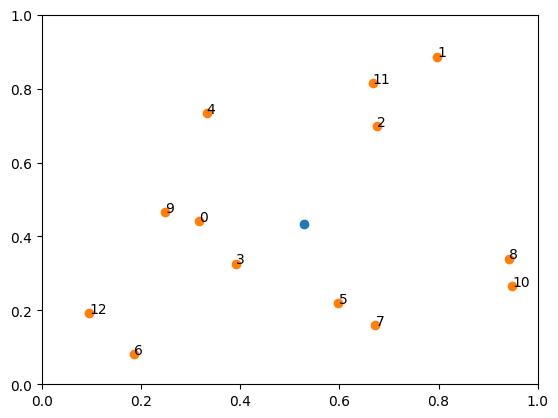

In [24]:
# Plot graph in physical space

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(labels[0][0], labels[0][1])
ax.scatter(nodes[0][0], nodes[0][1])
ax.set_xlim(0,1)
ax.set_ylim(0,1)

for i in range(len(nodes[0][0])):
    ax.annotate(i, (nodes[0][0][i], nodes[0][1][i]))

In [28]:
print(nodes[0])
labelplot = np.transpose(labels)
for i in range(len(nodes)):
    nodes[i] = np.transpose(nodes[i])
print(nodes[0])
edge_index = knn_graph(torch.Tensor(nodes[0]), 1)
print(edge_index)

[[0.31675834 0.79736546 0.67625467 0.39110955 0.33281393 0.59830875
  0.18673419 0.67275604 0.94180287 0.24824571 0.94888115 0.66723745
  0.09589794]
 [0.44183967 0.88647992 0.6974535  0.32647286 0.73392816 0.22013496
  0.08159457 0.1598956  0.34010018 0.46519315 0.26642103 0.8157764
  0.19329439]]
[[0.31675834 0.44183967]
 [0.79736546 0.88647992]
 [0.67625467 0.6974535 ]
 [0.39110955 0.32647286]
 [0.33281393 0.73392816]
 [0.59830875 0.22013496]
 [0.18673419 0.08159457]
 [0.67275604 0.1598956 ]
 [0.94180287 0.34010018]
 [0.24824571 0.46519315]
 [0.94888115 0.26642103]
 [0.66723745 0.8157764 ]
 [0.09589794 0.19329439]]
tensor([[ 9, 11, 11,  0,  9,  7, 12,  5, 10,  0,  8,  2,  6],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]])


In [18]:
def dist(node1, node2):
    x = np.absolute(node1[0] - node2[0])
    y = np.absolute(node1[1] - node2[1])
    return np.sqrt(np.power(x,2) + np.power(y,2))

def kNN(nodes):
    alldist = []
    for i in range(len(nodes)):
        distances = []
        for j in range(len(nodes)):
            distances.append(dist(nodes[i], nodes[j]))
        alldist.append(distances)
    return alldist

def kNN_full(dist, k):
    for i in range(len(dist)):
        